In [65]:
# A simple MLP implementation that learns multiplication of two numbers

In [104]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy import sqrt
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
# Dataset class. Prepare the dataset, normalize the inputs and targets, split into training and testing subsets

class MultiDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        
        # Normalize the dataset using Z norm
        self.x = (x - np.mean(x)) / np.std(x) 
        self.y = (y - np.mean(y)) / np.std(y) 
        
        # Alternatively can normalize dividing input and target by their respective max values
        #self.x = x / np.max(x) 
        #self.y = y / np.max(y)
        
        self.x = self.x.astype('float32')
        self.y = self.y.reshape(len(y), 1)
        self.y = self.y.astype('float32')
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]
    
    def get_splits(self, n_test = 0.33):
        test_size = round(n_test * len(self.x))
        train_size = len(self.x) - test_size
        
        return torch.utils.data.random_split(self, [train_size, test_size]) 
    
    def prepare_dataset(self):
        train, test = self.get_splits()
        train_dl = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True) # Test with larger batch numbers
        test_dl = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
        
        return train_dl, test_dl
        

In [68]:
# Multi-layer Perceptron model with 3 hidden layers

class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()        
        self.hidden1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, 200), torch.nn.Sigmoid())
        self.hidden2 = torch.nn.Sequential(torch.nn.Linear(200, 100), torch.nn.Sigmoid())        
        self.hidden3 = torch.nn.Sequential(torch.nn.Linear(100, 20), torch.nn.Sigmoid())
        self.output = torch.nn.Sequential(torch.nn.Linear(20,1))
    
    def forward(self, X):
        X = self.hidden1(X)
        X = self.hidden2(X)
        X = self.hidden3(X)
        X = self.output(X)

        return X

In [69]:
# Train the model

def train_model(train_dl, model, num_of_epochs=30):    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer performs better compared to SGD
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # Learning rate scheduler

    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1) # SGD optimizer
    error = [] # Collect errors for plotting
    lrs = []
    model.train()
    
    for epoch in range(1, num_of_epochs+1): # Train for the specified number of epochs
        for i, (inputs, targets) in enumerate(train_dl):        
            optimizer.zero_grad()
            y_hat = model(inputs)
            loss = criterion(y_hat, targets)
            loss.backward()
            optimizer.step()
            
        error.append(np.mean(loss.item())) 
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        if epoch % 5 == 0 or epoch == num_of_epochs: # Print loss at every 5th epoch
            print(f"Epoch {epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']:.5f}")
        
    plt.plot(error, label='Loss') 
    plt.plot(lrs, label='Lr') 
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.title('Model results')
    plt.show()

In [70]:
# Evaluate the model

def evaluate_model(test_dl, model):
    model.eval()
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        y_hat = model(inputs)
        y_hat = y_hat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        
        predictions.append(y_hat)
        actuals.append(actual)
        
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    mse = mean_squared_error(actuals, predictions)
    
    return mse

In [71]:
# Predict the output

def predict(row, model):
    row = torch.Tensor([row]) # Convert row to Torch tensor format
    row_norm = (row - np.mean(x)) / np.std(x) # normalise the input using Z norm
    y_hat = model(row_norm)
    y_hat = y_hat.detach().numpy()
    y_hat_norm = np.std(y) * y_hat + np.mean(y) # De-normalise the output 
    
    return y_hat_norm
    

In [72]:
# Initialise the model's linear layer weights

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [73]:
# Create the dataset containing two numbers as input and multiplication result as output

x = []
y = np.zeros(5000) # sample size

max_range = 15 # upper number limit

for d in range(len(y)):
    x.append([np.random.randint(1,max_range), np.random.randint(1,max_range)]) # Trained on ranges between 0 to 10. 

    y[d] = x[d][0] * x[d][1] 

x = np.array(x)

In [74]:
# Review the dataset

print(f"input: {x[1]}, output: {y[1]}") 

input: [2 8], output: 16.0


In [75]:
dataset = MultiDataset(x, y) # Create ataset class

In [76]:
train_dl, test_dl = dataset.prepare_dataset() # Prepare dataset with train and test subsets

In [77]:
print(len(train_dl), len(test_dl)) # Check the length of training and testing batch sizes

838 105


In [78]:
# Create MLP model with inputs of length 2. Initialize model weights
model = MLP(2) 
init_weights(model)

Epoch 5, Loss: 0.0016071876743808389, LR: 0.00077
Epoch 10, Loss: 0.0001318195427302271, LR: 0.00060
Epoch 15, Loss: 4.524023097474128e-05, LR: 0.00046
Epoch 20, Loss: 4.666887252824381e-05, LR: 0.00036
Epoch 25, Loss: 2.8873851988464594e-05, LR: 0.00028
Epoch 30, Loss: 1.7509806639282033e-05, LR: 0.00021


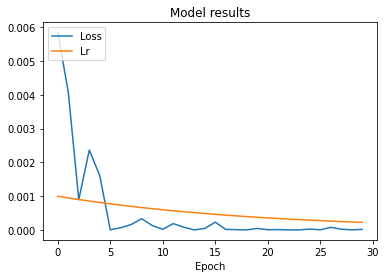

In [79]:
# Train the model for 30 epochs
train_model(train_dl, model, 30)

In [80]:
# Evaluate the model using mean square error and root mean square error
mse = evaluate_model(test_dl, model)
print("MSE: %.3f, RMSE: %.3f" % (mse, sqrt(mse)))

MSE: 0.000, RMSE: 0.006


In [95]:
# Test learned multiplication with some random samples 
for g in range(1,11):
    sample = np.array([np.random.randint(1,max_range), np.random.randint(1,max_range)])
    predicted = predict(sample, model).item()
    actual = sample[0] * sample[1]
    #error = abs(100 - (predicted * 100 / actual))
    error = mean_squared_error([predicted], [actual])
    print(f'{g} - Input: ({sample[0]},{sample[1]}). Predicted: {predicted:.3f}, actual: {actual}, error: {error:.3f}')

1 - Input: (14,8). Predicted: 111.962, actual: 112, error: 0.001
2 - Input: (1,5). Predicted: 5.323, actual: 5, error: 0.104
3 - Input: (4,5). Predicted: 20.165, actual: 20, error: 0.027
4 - Input: (6,3). Predicted: 18.271, actual: 18, error: 0.073
5 - Input: (8,12). Predicted: 95.920, actual: 96, error: 0.006
6 - Input: (12,10). Predicted: 120.004, actual: 120, error: 0.000
7 - Input: (5,4). Predicted: 20.152, actual: 20, error: 0.023
8 - Input: (14,2). Predicted: 28.199, actual: 28, error: 0.040
9 - Input: (12,6). Predicted: 72.022, actual: 72, error: 0.001
10 - Input: (8,9). Predicted: 72.133, actual: 72, error: 0.018


In [113]:
# Test learned multiplication with some random samples 
sample = []
predicted = []
actual = []
error = []

for g in range(0,10):
    sample.append(np.array([np.random.randint(1,max_range), np.random.randint(1,max_range)]))
    predicted.append(predict(sample[g], model).item())
    actual.append(sample[g][0] * sample[g][1])
    error.append(mean_squared_error([predicted], [actual]))
    
table = {'Input': sample, 
        'Predicted:': predicted,
        'Actual': actual,
        'Error': error
       }
pd.set_option("display.precision", 3)
df = pd.DataFrame(table)
display(df)

,Input,Predicted:,Actual,Error
0,"[8, 8]",64.200,64,0.040
1,"[9, 2]",18.372,18,0.089
2,"[9, 14]",125.987,126,0.060
3,"[10, 4]",40.551,40,0.120
4,"[6, 8]",48.360,48,0.122
5,"[10, 4]",40.551,40,0.152
6,"[1, 4]",4.299,4,0.143
7,"[5, 5]",25.169,25,0.129
8,"[5, 8]",40.406,40,0.133
9,"[5, 9]",45.384,45,0.134


In [111]:
with pd.option_context('display.float_format', '{:.3f}'.format):
    print(df)

     Input  Predicted:  Actual  Error
0  [11, 5]      55.314      55  0.098
1   [9, 6]      54.302      54  0.095
2  [11, 6]      66.104      66  0.067
3  [2, 12]      24.119      24  0.054
4  [12, 7]      83.947      84  0.043
5   [2, 9]      18.142      18  0.040
6   [9, 2]      18.372      18  0.054
7  [12, 8]      95.982      96  0.047
8   [2, 8]      16.157      16  0.045
9  [12, 3]      36.359      36  0.053


In [107]:
# Manually test a sample of numbers between 1-10
x1 = 12
x2 = 13
print("%.3f " % predict(np.array([x1,x2]), model).item(), (x1*x2))

155.958  156
